**Mental Health Text Classification using RoBERTa Transformer (PyTorch)
Dataset: Sentiment Analysis for Mental Health (Kaggle)
Task: Binary classification → Anxiety vs. Not Anxiety**



In [ ]:
# ============================================================
# 1️⃣ Import Required Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

2025-10-31 12:51:33.406219: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 12:51:33.420519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761895293.438069 2008175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761895293.443283 2008175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761895293.456808 2008175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# ============================================================
# 2️⃣ Load & Explore Dataset
# ============================================================
df = pd.read_csv("Combined Data.csv")
print("✅ Loaded dataset successfully!")
print("Shape:", df.shape)
print("\nStatus value counts:\n", df['status'].value_counts())

✅ Loaded dataset successfully!
Shape: (53043, 3)

Status value counts:
 status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [ ]:

# ============================================================
# 3️⃣ Data Preprocessing
# ============================================================

# Convert multiple classes into binary: Anxiety (1) vs. Others (0)
df['label'] = df['status'].apply(lambda x: 1 if x == 'Anxiety' else 0)
print("\nLabel distribution:\n", df['label'].value_counts())

# Train-validation split (80-20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['statement'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)



Label distribution:
 label
0    49155
1     3888
Name: count, dtype: int64


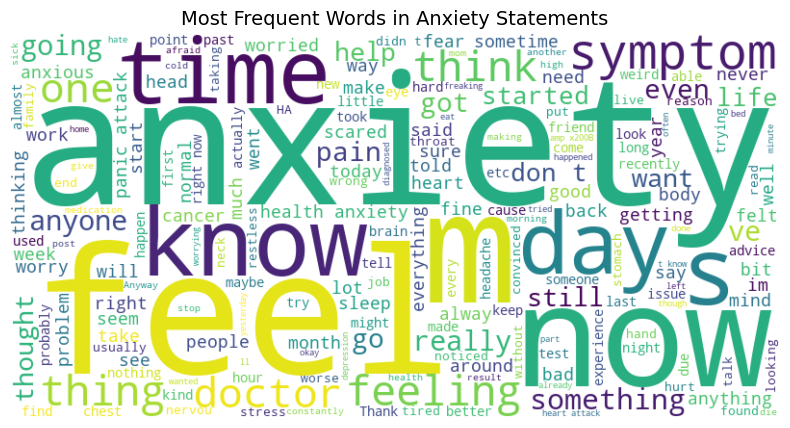

In [ ]:
# ============================================================
# 4️⃣ Exploratory Data Analysis (EDA)
# ============================================================

# WordCloud for frequent words in Anxiety-related texts
anxiety_text = " ".join(df[df['label'] == 1]['statement'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(anxiety_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Anxiety Statements", fontsize=14)
plt.show()

In [ ]:

# ============================================================
# 5️⃣ Tokenization using RoBERTa
# ============================================================
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True)

class MentalHealthDataset(Dataset):
    """Custom Dataset for Mental Health Text Classification"""
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
val_dataset = MentalHealthDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
# ============================================================
# 6️⃣ Model Setup
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Optimizer, Scheduler & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

epochs = 6
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [ ]:
# ============================================================
# 7️⃣ Training Loop with Early Stopping
# ============================================================
best_val_loss = np.inf
patience = 2
trigger_times = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    val_loss, preds, true_labels = 0, [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(true_labels, preds)
    val_f1 = f1_score(true_labels, preds, average='weighted')

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val F1:     {val_f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_roberta_model.pth")
        print("✅ Model saved!")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered!")
            break

print("\n🎯 Training Complete. Best model saved as best_roberta_model.pth")


Training Epoch 1/6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5305/5305 [05:59<00:00, 14.75it/s]



Epoch 1/6
Train Loss: 0.1726
Val Loss:   0.1097
Val Acc:    0.9771
Val F1:     0.9765
✅ Model saved!


Training Epoch 2/6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5305/5305 [05:55<00:00, 14.92it/s]



Epoch 2/6
Train Loss: 0.0961
Val Loss:   0.0839
Val Acc:    0.9804
Val F1:     0.9799
✅ Model saved!


Training Epoch 3/6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5305/5305 [05:55<00:00, 14.90it/s]



Epoch 3/6
Train Loss: 0.0646
Val Loss:   0.1020
Val Acc:    0.9803
Val F1:     0.9801


Training Epoch 4/6: 100%|████████████████████████████████████████████████████████████████████████████████████████| 5305/5305 [05:55<00:00, 14.91it/s]



Epoch 4/6
Train Loss: 0.0403
Val Loss:   0.1097
Val Acc:    0.9823
Val F1:     0.9821
⛔ Early stopping triggered!

🎯 Training Complete. Best model saved as best_roberta_model.pth


In [ ]:

# ============================================================
# 8️⃣ Final Evaluation
# ============================================================
model.load_state_dict(torch.load("best_roberta_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("\nFinal Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Not Anxiety", "Anxiety"]))
print("Final Accuracy:", accuracy_score(all_labels, all_preds))


Final Classification Report:

              precision    recall  f1-score   support

 Not Anxiety       0.99      0.99      0.99      9831
     Anxiety       0.91      0.81      0.86       778

    accuracy                           0.98     10609
   macro avg       0.95      0.90      0.92     10609
weighted avg       0.98      0.98      0.98     10609

Final Accuracy: 0.980394005090018


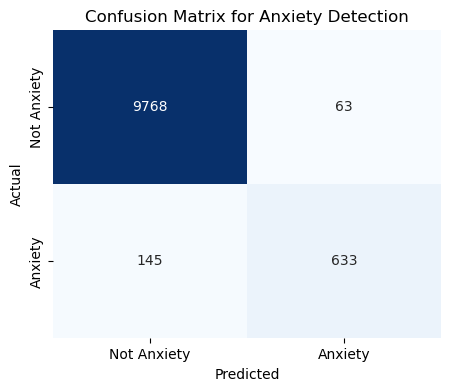

In [ ]:
# ============================================================
# 9️⃣ Visualization of Results
# ============================================================
plt.figure(figsize=(5,4))
sns.heatmap(
    pd.crosstab(np.array(all_labels), np.array(all_preds)),
    annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=["Not Anxiety", "Anxiety"],
    yticklabels=["Not Anxiety", "Anxiety"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Anxiety Detection")
plt.show()